### **Monolingual non-English BERT model for Text Classification**

Monolingual non-English BERT refers to a pre-trained language model using the BERT architecture, but trained only on a single language other than English. This type of model is designed to perform natural language processing tasks for a specific non-English language, such as question answering, sentiment analysis, and text classification. The model has been trained on large amounts of text data in the target language, allowing it to capture the nuances and characteristics of the language.

### Dataset

The GermEval 2019 shared task on German tweet analysis was a NLP competition focused on sentiment analysis and irony detection in German tweets. By fine-tuning a pre-trained BERT model on the GermEval 2019 dataset, participants could leverage the model's pre-trained knowledge of the **German language** to achieve strong results on the competition's tasks. 

Lets see how to detect and classify abusive language tweets using this dataset:

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('german'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import os
import shutil
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
import tensorflow_hub as hub

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd "/content/drive/My Drive/Colab Notebooks/transformers/BERT_text_classification_GERMAN/"

/content/drive/My Drive/Colab Notebooks/transformers/BERT_text_classification_GERMAN


In [ ]:
##reading data
df_ = pd.read_csv('germeval2019_training_subtask12.txt',sep='\t', lineterminator='\n',encoding='utf8',names=["tweet", "task1", "task2"])
df_test = pd.read_csv('germeval2019_Testdata_Subtask12.txt',sep='\t', lineterminator='\n',encoding='utf8',names=["tweet", "task1", "task2"])

In [ ]:
df_.head()

,tweet,task1,task2
0,@jouwatch Hat die Polizei keine Kanone mehr ? ...,OFFENSE,ABUSE
1,@de_sputnik @Saudi Arabien habt ihr mal wieder...,OFFENSE,ABUSE
2,"Glaube ich nicht , die Bundesregierung so wie ...",OFFENSE,ABUSE
3,Doch schockierend viele Jugendliche wissen ka...,OFFENSE,PROFANITY
4,Sein Charakter war ihm wichtiger anstatt als b...,OFFENSE,PROFANITY


### **EDA**

In [ ]:
df_.shape[0]

3980

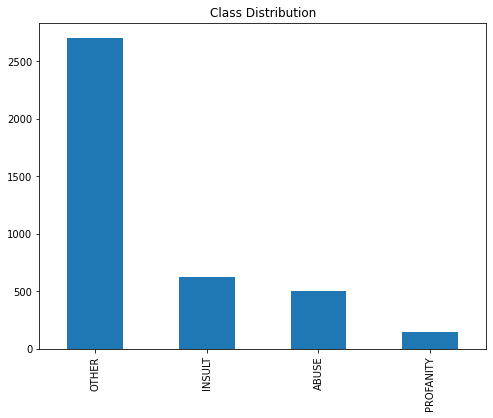

In [ ]:
df_['task2'].value_counts().plot(kind='bar',figsize=(8,6),title="Class Distribution")
plt.show()

Class imbalance exsists on the target variable, better correct it with under-sampling "OTHER"

In [ ]:
df_['task2'].value_counts()

OTHER        2698
INSULT        624
ABUSE         506
PROFANITY     152
Name: task2, dtype: int64

In [ ]:
df1 = df_[df_['task2']=='OTHER'].sample(500)
df2 = df_[df_['task2']!='OTHER']
df = pd.concat([df1,df2],axis=0)

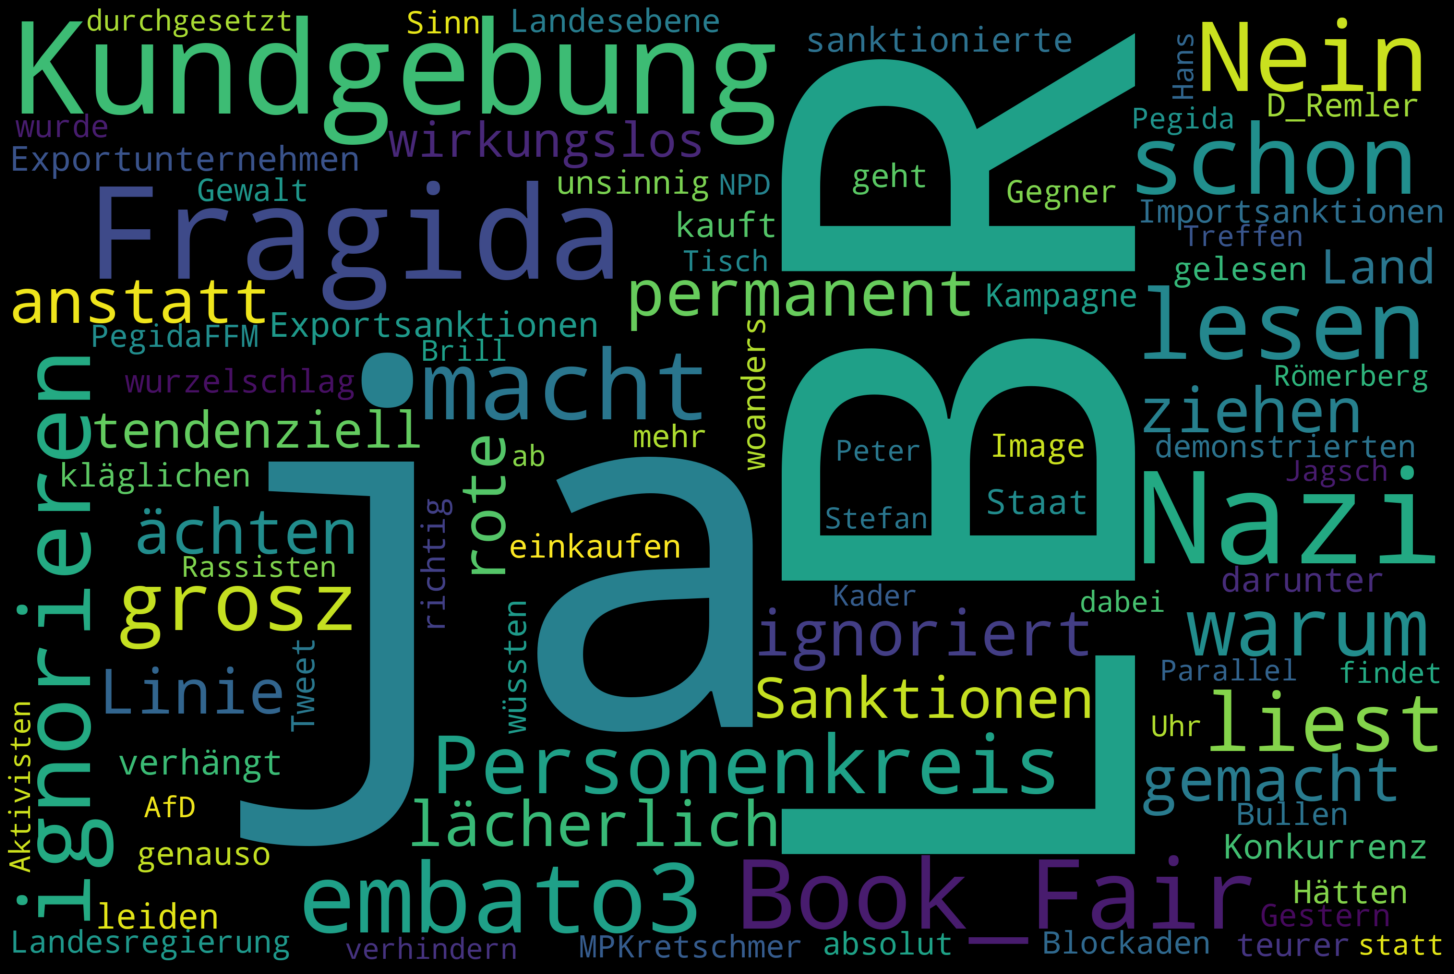

In [ ]:
text = df.tweet.values
wordcloud = WordCloud(
        width = 3000,
        height = 2000,
        background_color = 'black',
        stopwords = stop_words).generate(str(text))
fig = plt.figure(
        figsize = (20,15),
        facecolor = 'k',
        edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

kundgebung("rally"), Fertig ("Finished"), Fragida("Fragile") seems to be most prominent words.


In [ ]:
df = df[['tweet','task2']]
df = df.rename(columns={'task2':'class'})

le = LabelEncoder()
df['class'] = le.fit_transform(df['class'].values)

#### **Data** **Preparation**

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from transformers import BertTokenizer,TFBertModel
     
     

In [ ]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-german-cased")

Lets check encodings for an example:

In [ ]:

token = tokenizer.encode_plus(
    df['tweet'].iloc[0], 
    max_length=256, 
    truncation=True, 
    padding='max_length', 
    add_special_tokens=True,
    return_tensors='tf'
)
   

In [ ]:
token.input_ids

<tf.Tensor: shape=(1, 256), dtype=int32, numpy=
array([[    3, 26991,  2408, 14801, 26910, 26952, 12290, 26914,  2251,
        18114,   458, 26914,   295,  2241,  1035,   493, 26983, 19697,
         3278,   764, 26914,  1356,  9665,   718,    30,   194,    42,
           21, 24171, 26918,    21,    93, 18280,   127,  1120,   649,
        11751, 26914,  1356,  6024, 26972,  4453, 22166, 18366,   117,
        18114,   321,   309,  1567,  1319,    68,  2119,   266, 26918,
        19166,   155, 14737,  4219,    81,  5902,    42,   213,    81,
         1062,  2144, 26914,     4,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0, 

In [ ]:
X_input_ids = np.zeros((len(df), 256))
X_attn_masks = np.zeros((len(df), 256))

In [ ]:

def generate_training_data(df, ids, masks, tokenizer):
    for i, text in tqdm(enumerate(df['tweet'])):
        tokenized_text = tokenizer.encode_plus(
            text,
            max_length=256, 
            truncation=True, 
            padding='max_length', 
            add_special_tokens=True,
            return_tensors='tf'
        )
        ids[i, :] = tokenized_text.input_ids
        masks[i, :] = tokenized_text.attention_mask
    return ids, masks

In [ ]:
X_input_ids, X_attn_masks = generate_training_data(df, X_input_ids, X_attn_masks, tokenizer)

0it [00:00, ?it/s]

In [ ]:
labels = np.zeros((len(df), 4))
labels.shape
     

(1782, 4)

In [ ]:
# one-hot encoded target tensor
labels[np.arange(len(df)), df['class'].values] = 1 

In [ ]:

labels

array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       ...,
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.]])

In [ ]:
# creating a data pipeline using tensorflow dataset utility, creates batches of data for easy loading...
dataset = tf.data.Dataset.from_tensor_slices((X_input_ids, X_attn_masks, labels))
dataset.take(1) # one sample data

<TakeDataset element_spec=(TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(4,), dtype=tf.float64, name=None))>

In [ ]:
def OffensiveCommentFunction(input_ids, attn_masks, labels):
    return {
        'input_ids': input_ids,
        'attention_mask': attn_masks
    }, labels
     

In [ ]:
# converting to required format for tensorflow dataset 
dataset = dataset.map(OffensiveCommentFunction)

In [ ]:
# batch size, drop any left out tensor
dataset = dataset.shuffle(10000).batch(16, drop_remainder=True) 

In [ ]:
dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 256), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(16, 256), dtype=tf.float64, name=None)}, TensorSpec(shape=(16, 4), dtype=tf.float64, name=None))>

In [ ]:
p = 0.8
train_size = int((len(df))*p) 

In [ ]:
train_size
     

1425

In [ ]:
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)
     

### **Fine tune BERT Model**

In [ ]:
from transformers import TFBertModel

In [ ]:
# bert base model with pretrained weights
model = TFBertModel.from_pretrained('bert-base-german-cased') 

Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
# defining 2 input layers for input_ids and attn_masks
input_ids = tf.keras.layers.Input(shape=(256,), name='input_ids', dtype='int32')
attn_masks = tf.keras.layers.Input(shape=(256,), name='attention_mask', dtype='int32')

bert_embds = model.bert(input_ids, attention_mask=attn_masks)[1] # 0 -> activation layer (3D), 1 -> pooled output layer (2D)
intermediate_layer = tf.keras.layers.Dense(512, activation='relu', name='intermediate_layer')(bert_embds)
output_layer = tf.keras.layers.Dense(4, activation='softmax', name='output_layer')(intermediate_layer) # softmax -> calcs probs of classes

offensive_cmt_model = tf.keras.Model(inputs=[input_ids, attn_masks], outputs=output_layer)
offensive_cmt_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  109081344   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 256,                                           

In [ ]:
optim = tf.keras.optimizers.Adam(learning_rate=1e-5, decay=1e-6)
loss_func = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

In [ ]:
offensive_cmt_model.compile(optimizer=optim, loss=loss_func, metrics=[acc])

In [ ]:
hist = offensive_cmt_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5
)
     

Epoch 1/5
111/111 [==============================] - 112s 841ms/step - loss: 1.1730 - accuracy: 0.4550
Epoch 2/5
111/111 [==============================] - 93s 841ms/step - loss: 0.8782 - accuracy: 0.6430
Epoch 3/5
111/111 [==============================] - 93s 841ms/step - loss: 0.6210 - accuracy: 0.7686
Epoch 4/5
111/111 [==============================] - 93s 840ms/step - loss: 0.3866 - accuracy: 0.8654
Epoch 5/5
111/111 [==============================] - 93s 841ms/step - loss: 0.1942 - accuracy: 0.9476


dict_keys(['loss', 'accuracy'])


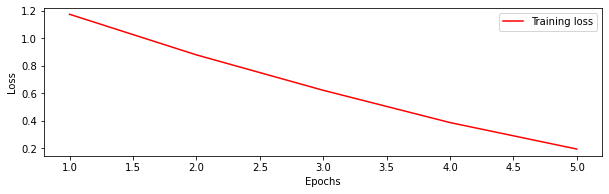

In [ ]:
history_dict = hist.history
print(history_dict.keys())

loss = history_dict['loss']

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
##save the model
dataset_name = 'Germeval2019'
saved_model_path = '/content/drive/My Drive/Colab Notebooks/transformers/BERT_text_classification_GERMAN/{}_bert'.format(dataset_name.replace('/', '_'))

offensive_cmt_model.save(saved_model_path, include_optimizer=False)

#### **Predictions**

In [ ]:
# offensive_cmt_model = tf.keras.models.load_model(saved_model_path)

tokenizer = BertTokenizer.from_pretrained("bert-base-german-cased")

def prepare_data(input_text, tokenizer):
    token = tokenizer.encode_plus(
        input_text,
        max_length=256, 
        truncation=True, 
        padding='max_length', 
        add_special_tokens=True,
        return_tensors='tf'
    )
    return {
        'input_ids': tf.cast(token.input_ids, tf.float64),
        'attention_mask': tf.cast(token.attention_mask, tf.float64)
    }

def make_prediction(model, processed_data, classes=['ABUSE','INSULT','OTHER','PROFANITY']):
    probs = model.predict(processed_data)[0]
    return classes[np.argmax(probs)]

Lets try-out predictions with some examples in our test dataset:

In [ ]:
df_test.head()

,tweet,task1,task2
0,@JanZimmHHB @mopo Komisch das die Realitätsver...,NaN,NaN
1,@faznet @Gruene_Europa @SPDEuropa @CDU CDU ste...,NaN,NaN
2,"@DLFNachrichten Die Gesichter, Namen, Religion...",NaN,NaN
3,@welt Wie verwirrt muss man sein um sich zu we...,NaN,NaN
4,@hacker_1991 @torben_braga Weil die AfD den Fe...,NaN,NaN


In [ ]:
print('org tweet:\n',df_test['tweet'][0])
print('English translation: \n Funny that the denial of reality always starts from pathetic left corrective accounts')
input_text = df_test['tweet'][0]
processed_data = prepare_data(input_text, tokenizer)
result = make_prediction(offensive_cmt_model, processed_data=processed_data)
print(f"Predicted Sentiment: {result}")

org tweet:
 @JanZimmHHB @mopo Komisch das die Realitätsverweigerung immer von linken erbärmlichen Correctiv Accounts ausgeht...
English translation: 
 Funny that the denial of reality always starts from pathetic left corrective accounts
1/1 [==============================] - 3s 3s/step
Predicted Sentiment: INSULT


In [ ]:
print('org tweet:\n',df_test['tweet'][24])
print("English translation: \n Since Berlin is a parasite and a recipient country, the donor countries paid for it, so they're happy...")
input_text = df_test['tweet'][24]
processed_data = prepare_data(input_text, tokenizer)
result = make_prediction(offensive_cmt_model, processed_data=processed_data)
print(f"Predicted Sentiment: {result}")

org tweet:
 @Tagesspiegel Da Berlin Schmarotzer und Nehmerland ist, haben es die Geberländer bezahlt, na die freuen sich...
English translation: 
 Since Berlin is a parasite and a recipient country, the donor countries paid for it, so they're happy...
1/1 [==============================] - 0s 67ms/step
Predicted Sentiment: ABUSE


In [ ]:
print('org tweet:\n',df_test['tweet'][10])
print('English translation: \n property is obliged to get the maximum out of it, and politics dances to match, sings the song of the brake on the fooling of tenants, and stares importantly into every piggy radio camera...')
input_text = df_test['tweet'][10]
processed_data = prepare_data(input_text, tokenizer)
result = make_prediction(offensive_cmt_model, processed_data=processed_data)
print(f"Predicted Sentiment: {result}")

org tweet:
 @rbbabendschau Nun, Eigentum verpflichtet, das Maximale aus diesem heraus zu holen, und die Politik tanzt passend dazu, singt das Lied der Mieterverarschungsbremse, und glotzen wichtig in jede Ferkelfunk Kamera...
English translation: 
 property is obliged to get the maximum out of it, and politics dances to match, sings the song of the brake on the fooling of tenants, and stares importantly into every piggy radio camera...
1/1 [==============================] - 0s 63ms/step
Predicted Sentiment: INSULT


In [ ]:
print('org tweet:\n',df_test['tweet'][36])
print('English translation: \n Oh, there is also that, was so nice and quiet around the...')
input_text = df_test['tweet'][36]
processed_data = prepare_data(input_text, tokenizer)
result = make_prediction(offensive_cmt_model, processed_data=processed_data)
print(f"Predicted Sentiment: {result}")

org tweet:
 @SPIEGELONLINE Ach den gibt es auch noch, war so schön still um den...
English translation: 
 Oh, there is also that, was so nice and quiet around the...
1/1 [==============================] - 0s 69ms/step
Predicted Sentiment: PROFANITY
